In [2]:
# Main Libraries
import torch.optim as optim
import torch.nn as nn
import torch
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Utility Libraries (QoL functions)
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split 
from torch.utils import data
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary

# Visualization and Evaluation Libraries
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df =  pd.read_csv('./datasets/housing/house-train.csv')

usefull_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF'
                , 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces'
                ,'LotFrontage','WoodDeckSF','OpenPorchSF'
                ,'ExterQual','Neighborhood','MSZoning'
                ,'Alley','LotShape','LandContour','Condition1','HouseStyle','MasVnrType','SaleCondition', 'SalePrice']

# **Problem 2A** 
Build a multi-perceptron network that regresses the housing price (based on 20%, 80% split). Use the same number of features we did in the lecture without one-hot encoding. Please plot the training and validation results and report final accuracy and model complexity

Epoch 50/50: 100%|██████████| 37/37 [00:00<00:00, 483.43 batch/s, Training Loss =0.107, Validation Loss =0.31, Validation RMSE =0.557]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]           5,632
            Linear-2                   [-1, 64]          16,448
            Linear-3                   [-1, 32]           2,080
            Linear-4                    [-1, 1]              33
Total params: 24,193
Trainable params: 24,193
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.09
Estimated Total Size (MB): 0.10
----------------------------------------------------------------
Final Training Loss: 0.10670455443124248
Final Validation Loss: 0.30977749293797635
Final Validation RMSE: 0.556576583174298


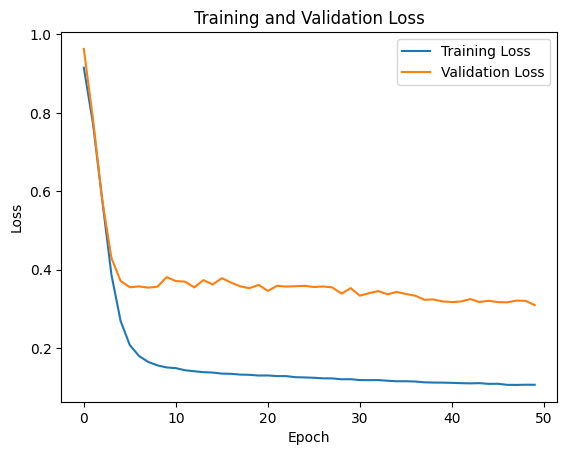

In [19]:
hf =  df[usefull_cols].copy()

features = hf.drop(['SalePrice'], axis=1)
targets = hf['SalePrice'].values.reshape(-1,1)

features = features.apply(pd.to_numeric, errors='coerce').fillna(0)
features = StandardScaler().fit_transform(features)
targets = StandardScaler().fit_transform(targets)

x_train, x_valid, y_train, y_valid = train_test_split(features, targets, test_size=0.2, random_state=0)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_valid = torch.tensor(x_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)


train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)

training_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)

#Definition of network model class
class RegressNet(nn.Module):
    def __init__(self, input):
        super(RegressNet, self).__init__()
        self.fc1 = nn.Linear(input, 256)  # 21 input features
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 32)    
        self.fc4 = nn.Linear(32, 1) # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))      
        x = self.fc4(x)
        return x

model = RegressNet(input=x_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 50
training_losses = []
validation_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    with tqdm(total=len(training_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit=' batch') as pbar:
        for inputs, labels in training_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            pbar.update(1)  # Update progress bar for each batch iteration

        running_loss /= len(training_loader.dataset)
        training_losses.append(running_loss)

        model.eval()
        validation_loss = 0.0
        validation_total = 0.0
        
        with torch.no_grad():
            for inputs, labels in validation_loader:            
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item() * inputs.size(0)
                validation_total += ((outputs - labels) ** 2).sum().item()
    
        validation_loss /= len(validation_loader.dataset)
        validation_losses.append(validation_loss)
        rmse = np.sqrt(validation_total / len(validation_loader.dataset))
        

        pbar.set_postfix({'Training Loss ': running_loss, 'Validation Loss ': validation_loss, 'Validation RMSE ': rmse})

## Another way to calculate model parameters
# total_params = sum(p.numel() for p in net.parameters())
# print(f'Total number of parameters in the model: {total_params}')

summary(model, input_size=(x_train.shape[1],))
print(f'Final Training Loss: {training_losses[-1]}')
print(f'Final Validation Loss: {validation_losses[-1]}')
print(f'Final Validation RMSE: {rmse}')
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# **Problem 2B** 
Build a multi-perceptron network that regresses the housing price (based on 20%, 80% split). Use the same number of features we did in the lecture, but this time also add on-hot encoding. Please plot the training and validation results and report the final accuracy and model complexity. Do you see the meaningful changes against 2.b.

Epoch 50/50: 100%|██████████| 19/19 [00:00<00:00, 414.13 batch/s, Training Loss =0.000587, Validation Loss =0.0125, Validation RMSE =0.112]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          20,480
            Linear-2                   [-1, 64]          16,448
            Linear-3                   [-1, 32]           2,080
            Linear-4                    [-1, 1]              33
Total params: 39,041
Trainable params: 39,041
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.15
Estimated Total Size (MB): 0.15
----------------------------------------------------------------
Final Training Loss: 0.0005866833500028269
Final Validation Loss: 0.012464619611632335
Final Validation RMSE: 0.11164506107599972


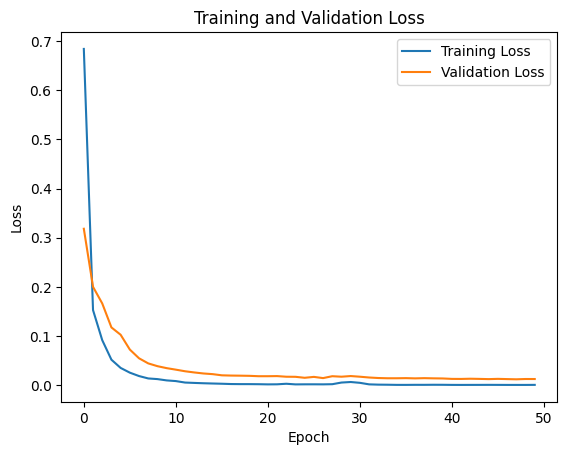

In [22]:
hf =  df[usefull_cols].copy()

encoded_features = pd.get_dummies(hf,columns=['Neighborhood','MSZoning','Alley','LotShape','LandContour','Condition1','HouseStyle','MasVnrType','SaleCondition'])
encoded_features = encoded_features.replace({True: 1, False: 0})
encoded_features = encoded_features.apply(pd.to_numeric, errors='coerce').fillna(0)

outputs = hf['SalePrice'].values.reshape(-1,1)

encoded_features = StandardScaler().fit_transform(encoded_features)
outputs = StandardScaler().fit_transform(outputs)

x_train, x_valid, y_train, y_valid = train_test_split(encoded_features, outputs, test_size=0.2, random_state=0)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_valid = torch.tensor(x_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)

training_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=False)

#Definition of network model class
class RegressNet(nn.Module):
    def __init__(self, input):
        super(RegressNet, self).__init__()
        self.fc1 = nn.Linear(input, 256)  # 21 input features
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 32)    
        self.fc4 = nn.Linear(32, 1) # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))      
        x = self.fc4(x)
        return x

model = RegressNet(input=x_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50
training_losses = []
validation_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    with tqdm(total=len(training_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit=' batch') as pbar:
        for inputs, labels in training_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            pbar.update(1)  # Update progress bar for each batch iteration

        running_loss /= len(training_loader.dataset)
        training_losses.append(running_loss)

        model.eval()
        validation_loss = 0.0
        validation_total = 0.0
        
        with torch.no_grad():
            for inputs, labels in validation_loader:            
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item() * inputs.size(0)
                validation_total += ((outputs - labels) ** 2).sum().item()
    
        validation_loss /= len(validation_loader.dataset)
        validation_losses.append(validation_loss)
        rmse = np.sqrt(validation_total / len(validation_loader.dataset))
        

        pbar.set_postfix({'Training Loss ': running_loss, 'Validation Loss ': validation_loss, 'Validation RMSE ': rmse})

## Another way to calculate model parameters
# total_params = sum(p.numel() for p in net.parameters())
# print(f'Total number of parameters in the model: {total_params}')

summary(model, input_size=(x_train.shape[1],))
print(f'Final Training Loss: {training_losses[-1]}')
print(f'Final Validation Loss: {validation_losses[-1]}')
print(f'Final Validation RMSE: {rmse}')
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# **Problem 2C** 
increase the complexity of the network for problem 2. b and compare your results against 2.b

Epoch 50/50: 100%|██████████| 37/37 [00:00<00:00, 426.43 batch/s, Training Loss =0.00864, Validation Loss =0.0113, Validation RMSE =0.106]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]           2,560
            Linear-2                    [-1, 8]             264
            Linear-3                    [-1, 4]              36
            Linear-4                    [-1, 2]              10
            Linear-5                    [-1, 1]               3
Total params: 2,873
Trainable params: 2,873
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
Final Training  Loss:  0.008639940296695249
Final Validation Loss: 0.011279434048608965
Final Validation RMSE: 0.10620467997507908


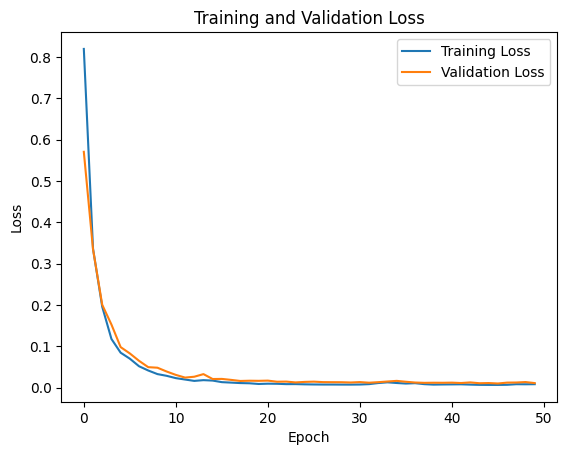

In [63]:
hf =  df[usefull_cols].copy()

encoded_features = pd.get_dummies(hf,columns=['Neighborhood','MSZoning','Alley','LotShape','LandContour','Condition1','HouseStyle','MasVnrType','SaleCondition'])
encoded_features = encoded_features.replace({True: 1, False: 0})
encoded_features = encoded_features.apply(pd.to_numeric, errors='coerce').fillna(0)

targets = hf['SalePrice'].values.reshape(-1,1)
encoded_features = StandardScaler().fit_transform(encoded_features)

targets = StandardScaler().fit_transform(targets)

x_train, x_valid, y_train, y_valid = train_test_split(encoded_features, targets, test_size=0.2, random_state=0)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_valid = torch.tensor(x_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)


train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)

training_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)

#Definition of network model class
class RegressNet(nn.Module):
    def __init__(self, input):
        super(RegressNet, self).__init__()
        self.fc1 = nn.Linear(input, 32)  # 21 input features
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 4)
        self.fc4 = nn.Linear(4, 2)
        self.fc5 = nn.Linear(2, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))  
        x = torch.relu(self.fc4(x))   
        x = self.fc5(x)
        return x

model = RegressNet(input=x_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 50
training_losses = []
validation_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    with tqdm(total=len(training_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit=' batch') as pbar:
        for inputs, labels in training_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            pbar.update(1)  # Update progress bar for each batch iteration

        running_loss /= len(training_loader.dataset)
        training_losses.append(running_loss)

        model.eval()
        validation_loss = 0.0
        validation_total = 0.0
        
        with torch.no_grad():
            for inputs, labels in validation_loader:            
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item() * inputs.size(0)
                validation_total += ((outputs - labels) ** 2).sum().item()
    
        validation_loss /= len(validation_loader.dataset)
        validation_losses.append(validation_loss)
        rmse = np.sqrt(validation_total / len(validation_loader.dataset))
        

        pbar.set_postfix({'Training Loss ': running_loss, 'Validation Loss ': validation_loss, 'Validation RMSE ': rmse})

## Another way to calculate model parameters
# total_params = sum(p.numel() for p in net.parameters())
# print(f'Total number of parameters in the model: {total_params}')

summary(model, input_size=(x_train.shape[1],))
print(f'Final Training  Loss:  {training_losses[-1]}')
print(f'Final Validation Loss: {validation_losses[-1]}')
print(f'Final Validation RMSE: {rmse}')
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()